# Bundesliga Data Analysis
A project to answer some analytical questions about the Bundesliga football league from data sets using pyspark and matplotlib

## Importing the libraries necessary
Pyspark is a python gateway to Apache Spark, it allows parallelisation of data processing across nodes or clusters which can be 100x faster.
This will also allow me to work with Pandas dataframes and SQL to perform some basic queries.
Matplotlib will allow me to plot some of the quantative data.

In [34]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import plotly as py
import calendar

In [13]:
spark = SparkSession \
        .builder \
        .appName("firstSpark") \
        .getOrCreate()

## Loading data into spark
This shows the top 5 things that exist inside of the Matches.csv file utilising sparks read function.

In [14]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

df_matches = load_dataframe('Data/Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



## toPandas()
Pandas is used as standard in the data industry and has a superior dataframe output. By utilising pysparks toPandas() function, we are able to benefit from the processing of spark while also using Pandas functionality.

In [16]:
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals","FinalResult"]
old_new_cols = [*zip(old_cols,new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col,new_col)

df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


# Performing data analysis
## Who are the winners of the D1 division in the Bundesliga between 2000 - 2010

To do this I will create two dataframes one for home games and one for away games. Once I have this then I can inner join the two dataframes containing a table of all aggregated games. From this a Window function can be use to further aggregate statistics on a season level and rank them based on winning percentage and goal difference. Goal difference is important as seasons that end in a tie on points are decided by goal difference.

In [17]:
df_matches = df_matches \
    .withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we are interested in season <= 2010 and >= 2000
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))

# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

In [18]:
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df


,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


In [23]:
# window = Window.partitionBy('Team').orderby('WinPct')
table.groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).limit(10).toPandas().round(1)

,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Leverkusen,11,47.3,17.8,16.1,10.0,7.9
1,Schalke 04,11,48.1,14.3,16.4,9.2,8.5
2,Werder Bremen,11,50.3,20.7,17.1,9.7,7.2
3,Wolfsburg,11,37.4,3.2,12.7,13.0,8.3
4,Hamburg,11,41.2,5.2,14.0,10.9,9.1
5,Stuttgart,11,44.4,9.6,15.1,10.1,8.8
6,Bayern Munich,11,60.7,35.5,20.6,5.8,7.5
7,Dortmund,11,45.5,14.2,15.5,8.8,9.7
8,Hertha,10,40.0,2.8,13.6,12.1,8.3
9,Hannover,9,34.0,-9.0,11.6,13.9,8.6


## Which teams have been relegated between 2000-2010?

In [27]:
# lets check for 2000s
relegated = table.filter((col('TeamPosition') == 16) | 
             (col('TeamPosition') == 17) |
             (col('TeamPosition') == 18)).orderBy(asc('Season')) 
relegated.filter((col('Season') >= 2000) & (col('Season') <= 2010)).toPandas()


,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Stuttgart,2000,42.0,49.0,-7.0,9,14,11,26.47,16
1,Unterhaching,2000,35.0,59.0,-24.0,8,15,11,23.53,17
2,Bochum,2000,30.0,67.0,-37.0,7,21,6,20.59,18
3,Freiburg,2001,37.0,64.0,-27.0,7,18,9,20.59,16
4,FC Koln,2001,26.0,61.0,-35.0,7,19,8,20.59,17
5,St Pauli,2001,37.0,70.0,-33.0,4,20,10,11.76,18
6,Bielefeld,2002,35.0,46.0,-11.0,8,14,12,23.53,16
7,Nurnberg,2002,33.0,60.0,-27.0,8,20,6,23.53,17
8,Cottbus,2002,34.0,64.0,-30.0,7,18,9,20.59,18
9,Munich 1860,2003,32.0,55.0,-23.0,8,18,8,23.53,17


## Which months have the highest goal to game ratio?

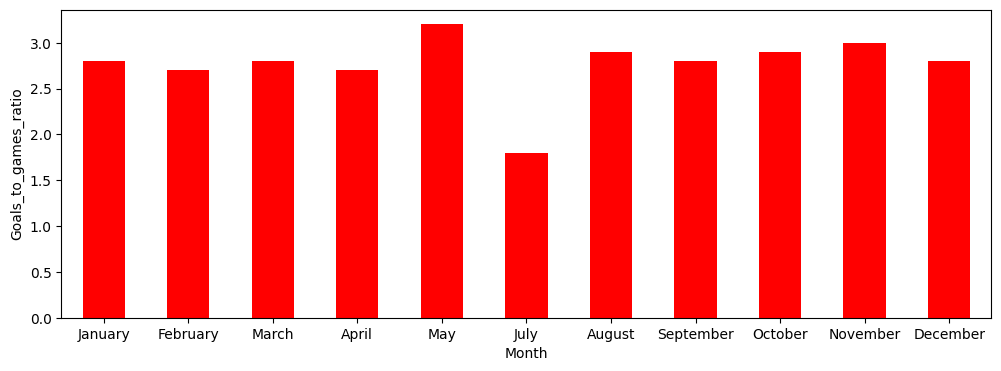

In [35]:
oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest_df = oktoberfest.toPandas()

oktoberfest_df = oktoberfest_df.sort_values('Month')
oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals_to_games_ratio')
plt.show()